In [5]:
from __future__ import absolute_import, division, print_function

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO, TracePredictive
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.util import diagnostics

import pyro.optim as optim
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve, confusion_matrix
from pyro.ops.stats import waic
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from copy import deepcopy
import pickle
from mpl_toolkits.mplot3d import Axes3D


pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.0')
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
from utils import *
from model import *

In [2]:
mode = "fast"

# Conditional Auto-Regressive Modelling of Crimes in New York City
## Rakshita Raguraman and Shruti Subramaniyam (rr3201, ss5600)

The goal of our project is to model the socio-economic and spatio-temporal crime data of New York in order to predict the potentially high-risk tracts in the city. Our problem is a binary classification problem, (1: high risk and 0: low risk). Spatial auto-correlation is the tendency for adjacent areas to share similar characteristics. Conditional Auto-Regressive (CAR) and Intrinsic Conditional Auto-Regressive (ICAR) models, first introduced by Besag (1974), account for this by pooling information from neighboring regions.

## Data Description

In order to collect the data for our analysis, we decided to use the New York Crime data. Our collection process involved merging 2 publicly available datasets and augmenting those with public buildings like restaurants and bars in the vicinity of the precinct. 

1. Crime data of New York. (data, latitude, longitude, type of crime)
2. Census data of New York. (census tract, blovk, 
3. Public spaces. (added using (latitude, longitude) pair of census data and aggregating over all the blocks to get the tract-wise information) 

## Let's have a look at the dataset

## First, let's just start with socio-economic features

In [30]:
data = data_csv('only_space')

<img src="corr.jpeg">

## Based on the above set of correlations, we decided to shorten our list of features to the following: 


In [31]:
features = ['TotalPop','Income','Poverty','Office','Construction','Production','WorkAtHome', 'PrivateWork','SelfEmployed','FamilyWork','restaurants','subway_station']

The above features were collected per census tract of New York. Based on this, we get the number of Felonies, Misdemeanors and Violations for each day. First we set number of crimes as felonies + misdemeanors + violations. Then we aggregated them for each tract by summing over all the days. Then, through empirical means, we determined a reasonable cutoff and offset which will decide whether the area is a high risk or low risk area. 

## Now let's get the dataset

In [32]:
data, X_nuts_train, y_nuts_train, month_train, X_nuts_test, y_nuts_test, month_test = get_data(data, features, bool_split=BOOL_SPLIT_SPACE, offset=OFFSET_SPACE)

In [33]:
tnse_dict = get_tnse_dict(X_nuts_train, X_nuts_test)

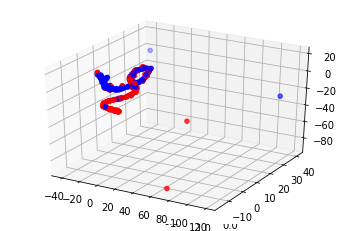

In [34]:
f = low_dim_3d(tnse_dict, y_nuts_test.numpy())

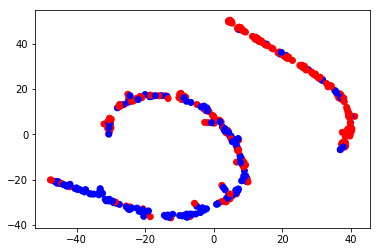

In [35]:
f = low_dim_2d(tnse_dict, y_nuts_test.numpy())

(0, 15000)

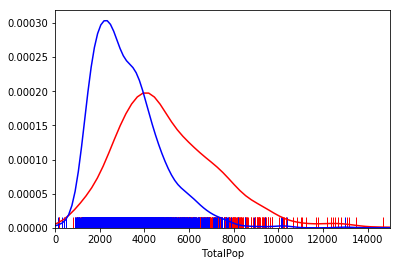

In [36]:
plt.clf()
sns.distplot(data[data['binary_target']==1]['TotalPop'], hist=False, rug=True, color='r');
sns.distplot(data[data['binary_target']==0]['TotalPop'], hist=False, rug=True, color='b');
plt.xlim(0, 15000)

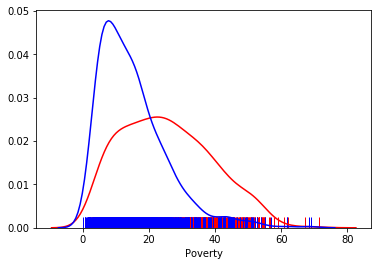

In [37]:
sns.distplot(data[data['binary_target']==1]['Poverty'], hist=False, rug=True, color='r');
sns.distplot(data[data['binary_target']==0]['Poverty'], hist=False, rug=True, color='b');

## Modelling
Now let us get into the Modelling. First, to begin with, we ran a simple sklearn Logistic Regression model to sort of serve as a baseline. This will also give us an idea of which features have more importance than other. 

In [38]:
reg = LogisticRegression(C=0.8).fit(X_nuts_train, y_nuts_train)
print('Train Score : ',reg.score(X_nuts_train, y_nuts_train))
print('Test Score :', reg.score(X_nuts_test, y_nuts_test))
print('-'*30)

Train Score :  0.7133431085043989
Test Score : 0.7105263157894737
------------------------------


## Model 1: Baseline Bayesian Model: 

<img src="model1.png">

We now model a bayesian logistic regressor. The features here only depend on the socio-economic patterns, as we are now not considering time or space. 
$Y(i)$ is the binary response variable for the $i-$th tract. 
\begin{align*}
Y(i) &\sim \textrm{Bernoulli}(p(i)) \\
\textrm{Where } p(i) &\textrm{ is modelled as a logistic regressor } \\
\textrm{logit}(p(i)) &= log[\dfrac{p(i)}{1-p(i)}] \\
\textrm{logit}(p(i)) &= \beta_0 + \beta_1 x_i(i)+...+\beta_k x_k(i) \\
\end{align*}
Where $x_i$'s are the socia-economic features picked earlier

Priors are initialized as follows : 
\begin{align*}
P(\beta_i) &= N(0,10) \\
\end{align*}


In [39]:
if mode=="slow":
    svi_model_1, elbo_arr_model_1 = infer(X_nuts_train, y_nuts_train, model_baseline, guide_baseline)
    model_preds_model_1, y_pred_model_1, acc_model_1, preds_1 = predict(X_nuts_test, y_nuts_test, model_baseline, guide_baseline, node1=None, node2=None, month=None, num_samples=100)
else:
    d = pickle.load(open('Results/model_1_73_subset', 'rb'))
    #NOTE: uses only num_samples = 100.
    model_preds_model_1, y_pred_model_1, acc_model_1, elbo_arr_model_1, preds_model_1  = d['model_preds'], d['y_pred'], d['acc'], d['elbo_arr'], d['preds']

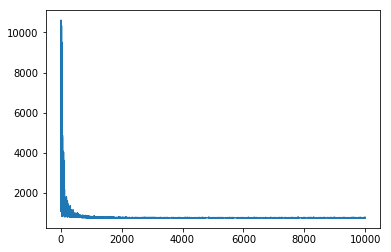

In [40]:
plt.plot(elbo_arr_model_1)

In [41]:
acc_model_1

0.7368421052631579

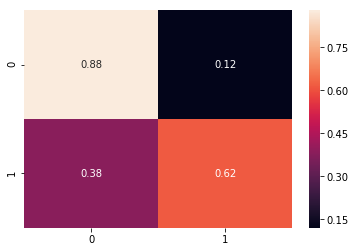

In [42]:
print_confusion_matrix(y_nuts_test, y_pred_model_1)

## Increasing number of samples from posterior for predictions

<img src="num_samples.jpeg">

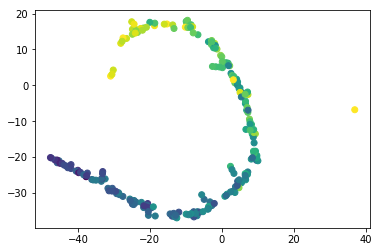

In [43]:
confidence_negative(tnse_dict, model_preds_model_1)

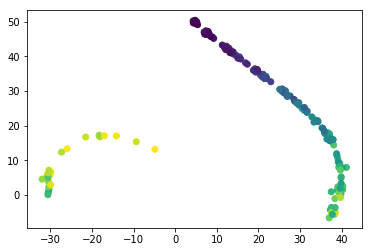

In [44]:
confidence_positive(tnse_dict, model_preds_model_1)

## Drawbacks of this model are:
We do not consider the spatial relationships at all. $Y(i)$ which is the response variable for the tract is pretty much fixed for a particular tract. So to model spatial randomness, we start off by adding unstructures spatial Gaussian noise. 

So, first, we try incorporating a random space component. This brings us to: 



### Now let us look at spatial data trends


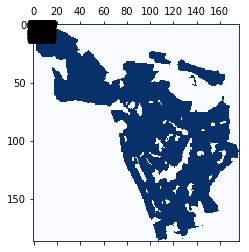

In [45]:
generate_nyc_neighbours()


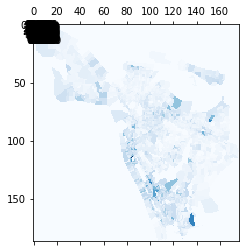

In [46]:
generate_crime_heatmap()

This brings us to: 

## Model 2: Incorporating Random Noise
<img src="model2.png">

We can observe the effect that neighbours have on each other

$Y(i)$ is the binary response variable for the $i-$th precinct. 
\begin{align*}
Y(i) &\sim \textrm{Bernoulli}(p(i)) \\
\textrm{Where } p(i) &\textrm{ is modelled as a logistic regressor } \\
\textrm{logit}(p(i)) &= log[\dfrac{p(i)}{1-p(i)}] \\
\textrm{logit}(p(i)) &= \beta_0 + \beta_1 x_i(i)+...+\beta_k x_k(i) + U(i) \\
U(i) &\sim N(0, \sigma_u^2)
\end{align*}\
$U(i)$ is the unstructured spatial random effect (noise) added. Without this, the limitation is $p(i)$ is fixed for each $i$.

Priors are as follows : 
\begin{align*}
P(\beta_i) &= N(0,10) \\
\tau_u &= \dfrac{1}{\sigma_u^2} \\
P(\tau_u) &= \textrm{Gamma} (0.001,0.001) \\
\end{align*}

Due to some difficulties with nan loss we had with Pyro and with some suggestions we got online, we increased Gamma prioirs to 0.5.

In [47]:
if mode=="slow":
    num_samples = 100
    svi_model_2, elbo_arr_model_2 = infer(X_nuts_train, y_nuts_train, model_baseline, guide_baseline)
    model_preds_model_2, y_pred_model_2, acc_model_2, preds_2 = predict(X_nuts_test, y_nuts_test, model_2, guide_2, node1=None, node2=None, month=None, num_samples=100)
    pickle_it(model_preds_model_2, y_pred_model_2, acc_model_2, preds_2, elbo_arr_model_2, "model_2_{}_subset_{}".format(acc_model_2, num_samples))
else:
    d = pickle.load(open('Results/model_2_73_subset_100', 'rb'))
    #NOTE: uses only num_samples = 100.
    model_preds_model_2, y_pred_model_2, acc_model_2, preds_2, elbo_arr_model_2 = d['model_preds'], d['y_pred'], d['acc'], d['preds'], d['elbo_arr']

In [48]:
acc_model_2

0.7368421052631579

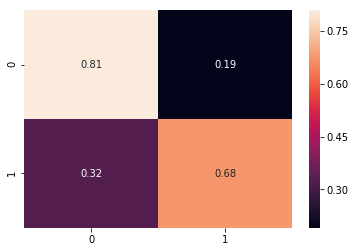

In [49]:
print_confusion_matrix(y_nuts_test, y_pred_model_2)

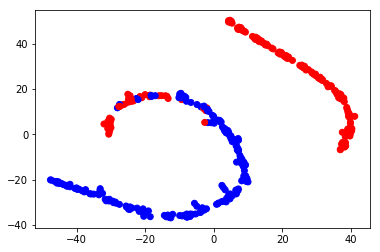

In [50]:
f = low_dim_2d(tnse_dict, y_pred_model_2)

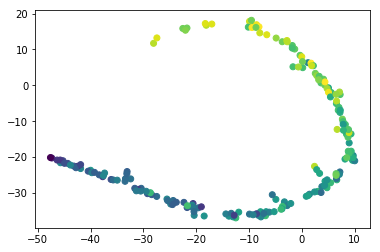

In [51]:
confidence_negative(tnse_dict, model_preds_model_2)

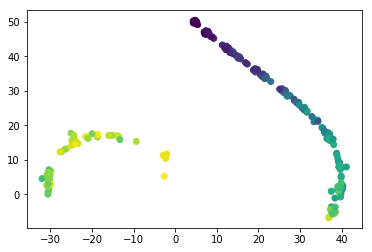

In [52]:
confidence_positive(tnse_dict, model_preds_model_2)

# Model 3 : Using ICAR Model for structured spatial noise
<img src="model3.png">

Now, we want to add structured spatial noise. It is clear from the intutions and maps generated above that neighbourhoods influence each other when it comes to crime. ICAR models account for the spatial correlations by pooling information from the neighbourhoods. Below we describe the model with ICAR to model the spatial data. 

Just to recap: 

$Y(i)$ is the binary response variable for the $i-$th precinct. 

\begin{align*}
Y(i) &\sim \textrm{Bernoulli}(p(i)) \\
\textrm{Where } p(i) &\textrm{ is modelled as a logistic regressor } \\
\textrm{logit}(p(i)) &= log[\dfrac{p(i)}{1-p(i)}] \\
\end{align*}
Now we bring in the ICAR term as well:
\begin{align*}
\textrm{logit}(p(i)) &= \beta_0 + \beta_1 x_i(i)+...+\beta_k x_k(i) + U(i) + \phi(i) \\
U(i) &\sim N(0, \sigma_u^2)
p(\phi_i|\phi_j) \sim N \left(\sum_{j=1}^{N} w_{ij}\phi_j, \sigma^2 \right)   \\
\end{align*} \
Here $i \sim j$ means that node $j$ in a neighbor of node $i$ and $w_{ij}=1$
This encodes the relationship that neighbouring precincts have on each other.
The joint of $\phi$ with **zero mean and variance** $\sigma^2$ is:
\begin{align*}
\phi &\sim N(0,Q^{-1}) \\
Q &= D(I - \alpha W)
\end{align*}
Here, D is a diagonal matrix containing the number of neighbors for that node and $\alpha$ is the parameter that controls amount of spatial dependence. 

Priors are as follows : 
\begin{align*}
P(\beta_i) &= N(0,10) \\
\tau_u &= \dfrac{1}{\sigma_u^2} \\
\tau_w &= \dfrac{1}{\sigma_s^2} \\
P(\tau_u) &= \textrm{Gamma} (0.001,0.001) \\
\end{align*}

For the model specified above, 

log probability density  $\propto \frac{n}{2} log(\det(Q)) - \frac{1}{2}\phi^{T}Q\phi$  where n is the number of nodes

Since MCMC samples try to estimate the log posterior, this computation is of the order of $n^3$ (caculation of determinant, each iteration of MCMC is computationally expensive. In our case n = 2078, hence we will have more than 4 billion operations per iteration.

The ICAR model sets $\alpha=1$ thus making $Q$ a constant. Hence, now for calculation of log probability, we require only $n^2$ operations since determinant is constant now. 

\begin{align*}
p(\phi_i|\phi_j) &= N\left(\frac{\sum_{i \sim j} \phi_i}{d_i}, \frac{\sigma_s^2(i)}{d_i}\right)    \\
\end{align*} 
Here $i \sim j$ means that node $j$ in a neighbor of node $i$ and $ i \neq j$ and $d_i$ denotes number of neighbors of tract/node $i$. \
This encodes the relationship that neighbouring precincts have on each other.\
The joint of $\phi$ with **zero mean and unit variance** is:
\begin{align*}
p(\phi) &\propto exp \left( -\frac{1}{2} \sum_{i \sim j}(\phi_i - \phi_j)^2\right)  \\
mean(\phi) &= \frac{\sum_N{\phi_i}}{N} = 0 \\
&\implies sum(\phi) = 0
\end{align*}


Priors are as follows : 
\begin{align*}
P(\beta_i) &= N(0,10) \\
\tau_u &= \dfrac{1}{\sigma_u^2} \\
\tau_w &= \dfrac{1}{\sigma_s^2} \\
P(\tau_u) &= \textrm{Gamma} (0.001,0.001) \\
\end{align*}

We tried implementing a vanilla version of the ICAR model, but our NUTS sampling took well over 30 minutes to generate for one single iteration. Hence, we explored a vectorized approach of the same expoliting the fact that in our dataset, a node has 3.62 neighbors on an average hence making W extremely sparse.

The approach used was to change the representation of the graph from adjacency matrix to adjacency list, i.e., to store the edge information only.

For example 

<img src="icar.png">


<img src="icar2.png">


<img src="icar3.png">
        
What this gives us now, is a vectorized implementation of the above equation where, 

\begin{align*}
    p(\phi) \propto exp(-0.5 * dot product(\phi(node1), \phi(node2))) 
\end{align*}

In [3]:
node1, node2 = get_nodes(hops=1)

In [56]:
if mode=="slow":
    num_samples = 100
    svi_model_icar, elbo_arr_model_icar = infer(X_nuts_train, y_nuts_train, model_baseline, guide_baseline, node1=node1, node2=node2)
    model_preds_model_icar, y_pred_model_icar, acc_model_icar, predictions_icar = predict(X_nuts_test, y_nuts_test, model_icar, guide_icar, node1=node1, node2=node2, month=None, num_samples=num_samples)
    pickle_it(model_preds_model_icar, y_pred_model_icar, acc_model_icar, predictions_icar, elbo_arr_model_icar, "model_2_{}_subset_{}".format(acc_model_icar, num_samples))
else:
    d = pickle.load(open('Results/icar_1_50_100', 'rb'))
    #NOTE: uses only num_samples = 100.
    model_preds_model_icar, y_pred_model_icar, acc_model_icar, elbo_arr_model_ocar, preds_icar = d['model_preds'], d['y_pred'], d['acc'], d['elbo_arr'], d['preds']

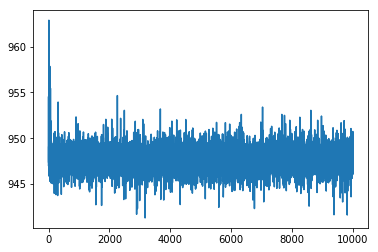

In [58]:
plt.plot(elbo_arr_model_ocar)

In [60]:
acc_model_icar

0.5350877192982456

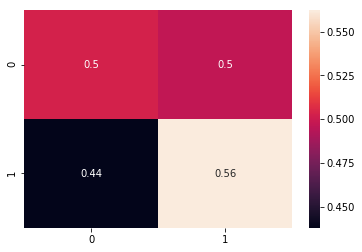

In [61]:
print_confusion_matrix(y_nuts_test.numpy(), y_pred_model_icar)

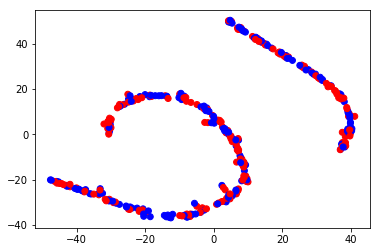

In [62]:
f = low_dim_2d(tnse_dict, y_pred_model_icar)

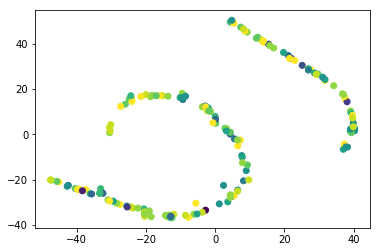

In [63]:
confidence_negative(tnse_dict, model_preds_model_icar)

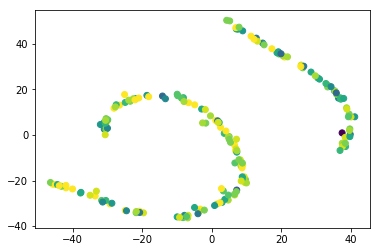

In [64]:
confidence_positive(tnse_dict, model_preds_model_icar)

### Key observations
1. Initially, we made a mistake and we used the month aggregated data for the ICAR model. This achieved 70% accuracy. Upon further analysis, we realized that we were wrong in that we needed to take the tract aggregated data as monthly data is not observed to be linear. The performance was quite surprising, considering that monthly trends are not linear. The 70% accuracy could also be because of the power of the other features. 

2. Below, we analyze the correlation matrix of $\phi$ and compare it with our neighborhood matrix (1 if neighbour and 0 otherwise) in order to see if any patterns are getting learnt. Although the similarities in phi are not extremely high for neighbours, a pattern is definitely visible. 

3. We realize that the poor accuracy is an issue of data. Considering point 1, the performance could have been because of the power of data that comes from 20,000 points along with the other important socio-economic features. In this case, we have only 2k data points (1 for each tract) and more than 2k parameters (we have 2k values of phi and then other parameters like beta). 

- Mean of each $\phi_i$ is average of neighbors

- Variance decreases as number of neighbors increases

- $(\phi_i - \phi_j)^2$ : penalty based on distance between neighboring values


In [65]:
d = {key: pd.Series(list(val.numpy())) for key, val in preds_icar.items() if "phi" in key }
df = pd.DataFrame(d)
for key, val in preds_icar.items():
    if "phi" in key:
        df[key] = list(val.numpy().mean(axis=1))

To understand further how the model learnt the spatial trends, let us now plot a graph

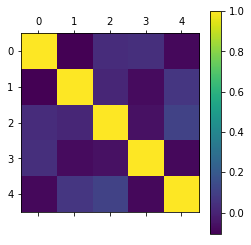

In [66]:
d = plt.matshow(df[['phi'+str(i) for i in range(5)]].corr())
cb = plt.colorbar()

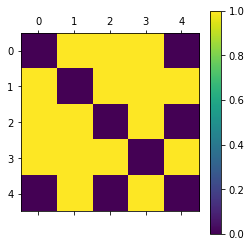

In [67]:
d = plt.matshow(pickle.load(open("weight_matrix", "rb"))[:5,:5])
cb = plt.colorbar()

We tried increasing the hops, but the effect of increasing neighbours does not help. As long as the neighbors are in the same connected component, their correlations will be learnt. This was also pointed out by the authors of the ICAR paper. Below we have the results of the neighbourhood (hops=2) VS correlation of phi to show that phi did not change. 

<img src='2hops.jpg'>

## To think about the further extensions, we first analyze the time vs crime



We tried modelling time linearly by year accoring to the paper. 


Now we bring in the time term as well:
\begin{align*}
\textrm{logit}(p(i)) &= \beta_0 + \beta_1 x_i(i)+...+\beta_k x_k(i) + U(i) + \phi(i) \times t \\
\end{align*} 
Here $t$ = year number (0 for 2015, 1 for 2016)


In [31]:
data_yr = pd.read_csv('raw_data/data_year_tract.csv')
data_yr['month'] = data_yr.apply(lambda row : row['year']-2015, axis=1)
features = ['month','TotalPop','Income','Poverty','Office','Construction','Production','WorkAtHome', 'PrivateWork','SelfEmployed','FamilyWork']


In [40]:
data_yr, X_nuts_train, y_nuts_train, month_train, X_nuts_test, y_nuts_test, month_test = get_data(data_yr, features, bool_split=75, offset=2,has_time_data=True)

In [33]:
if mode=="slow":
    num_samples = 100
    svi_model_time, elbo_arr_model_time = infer(X_nuts_train, y_nuts_train,model_spatio_temporal_linear_one_icar, guide_spatio_temporal_linear_one_icar,node1=node1, node2=node2,month=month_train)
    model_preds_model_time, y_pred_model_time, acc_model_time, preds_time = predict(X_nuts_test, y_nuts_test,model_spatio_temporal_linear_one_icar, guide_spatio_temporal_linear_one_icar,
                                   node1=node1, node2=node2,month=month_test)
else:
    d = pickle.load(open('Results/model_4_58_subset_01', 'rb'))
    #NOTE: uses only num_samples = 100.
    model_preds_model_time, y_pred_model_time, acc_model_time, elbo_arr_model_time, preds_time = d['model_preds'], d['y_pred'], d['acc'], d['elbo_arr'], d['samples']

In [34]:
acc_model_time

0.5895522388059702

## Next Steps
Looking at the time series trends shown below, we feel that modelling year linearly does not add any value. Further there is only data for 2 years. 

## Total crimes across time 
<img src="time1.png" width="400" height="400">

## Patterns in monthly number of crimes for years in data
<img src="time2.png" width="700" height="700">

## Monthly average of crimes
<img src="time3.png" width="400" height="400">

While analyzing we observed that there is a seasonal / monthly trend so it would be better to model months in terms of their average crimes over 10 years.
Now we bring in the time term as well:
\begin{align*}
\textrm{logit}(p(i)) &= \beta_0 + \beta_1 x_i(i)+...+\beta_k x_k(i) + U(i) + \phi(i) \times t \\
\end{align*} 
Here $t$ = normalized average number of crimes for that month

In [20]:
d = pickle.load(open('Results/model_5_33_subset.pkl', 'rb'))
#NOTE: uses only num_samples = 100.
model_preds_model_time_2, y_pred_model_time_2, acc_model_time_2, elbo_arr_model_time_2 = d['model_preds'], d['y_pred'], d['acc'], d['elbo_arr']

In [21]:
acc_model_time_2

0.3333333333333333

# Further Work:

We contacted Mitzi regarding the ICAR model implementation and convergence issues in pyro. She said that our code looked okay except that ICAR is a very challenging model to converge. We have set up a meeting to discuss and further dissect the performance of ICAR. We further plan to work on the modelling of time for this problem, possibly by combining a time series model with the spatial model in order to account for the non linearity in time. 

## References:
1. Bayesian hierarchical spatial models: Implementing the Besag York Mollié model in stan
Mitzi Morris Katherine Wheeler-Martin Dan Simpson Stephen J.Mooneyd AndrewGelman CharlesDiMaggio

2. Law, J. and Haining, R. (2004), A Bayesian Approach to Modeling Binary Data: The Case of High‐Intensity Crime Areas. Geographical Analysis, 36: 197-216. doi:10.1111/j.1538-4632.2004.tb01132.x

3.  Pyro tutorials & user forums
